[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/GabbyTab/boofun/blob/main/notebooks/hw4_hypercontractivity.ipynb)

# Problem Set 4: Hypercontractivity, KKL, and Noise Stability

**CS 294-92: Analysis of Boolean Functions - Spring 2025**  
**Due: Monday, April 7, 11:59PM**
**Notebook by: Gabriel Taboada**

This notebook explores the crown jewels of Boolean function analysis:
1. Hypercontractivity and Bonami's Lemma
2. The KKL Theorem (influential variables exist)
3. Friedgut's Junta Theorem
4. Noise stability of LTFs
5. The "Majority is Stablest" connection

**Reference**: O'Donnell, *Analysis of Boolean Functions*, Chapter 9

---

In [1]:
# Install/upgrade boofun (required for Colab)
# This ensures you have the latest version with all features
!pip install --upgrade boofun -q

import boofun as bf
print(f"BooFun version: {bf.__version__}")


[notice] A new release of pip is available: 25.2 -> 26.0
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


/Users/gabrieltaboada/dev/Boofun/boofun/src/boofun/core/errormodels.py:21: UserWarning: uncertainties library not available - some error models disabled
  warnings.warn("uncertainties library not available - some error models disabled")


/Users/gabrieltaboada/dev/Boofun/boofun/src/boofun/quantum/__init__.py:22: UserWarning: Qiskit not available - quantum features limited
  warnings.warn("Qiskit not available - quantum features limited")


BooFun version: 1.1.1


In [ ]:
import numpy as np
import boofun as bf
from boofun.analysis import PropertyTester
from boofun.analysis.hypercontractivity import bonami_lemma_bound, kkl_lower_bound
from boofun.families import MajorityFamily, ParityFamily, GrowthTracker
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
np.random.seed(42)

## Background: The Noise Operator

The **noise operator** $T_\rho$ for $-1 \leq \rho \leq 1$:
$$(T_\rho f)(x) = \mathbf{E}_y[f(y)] \text{ where } y_i = \begin{cases} x_i & \text{w.p. } \frac{1+\rho}{2} \\ -x_i & \text{w.p. } \frac{1-\rho}{2} \end{cases}$$

In Fourier terms:
$$(T_\rho f)\hat{\ }(S) = \rho^{|S|} \hat{f}(S)$$

**Noise stability**: $\mathbf{Stab}_\rho[f] = \langle f, T_\rho f \rangle = \sum_S \rho^{|S|} \hat{f}(S)^2$

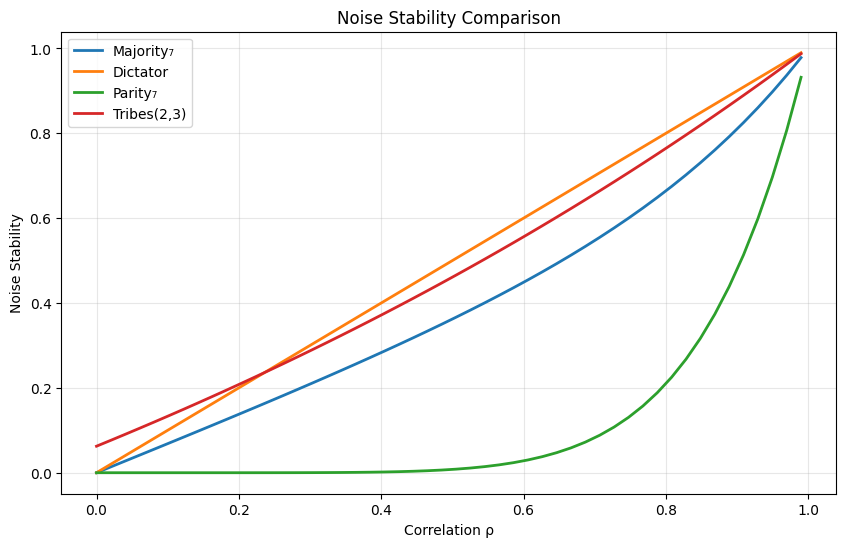

Key observations:
  • Dictator: Most stable (depends on just one variable)
  • Majority: Second most stable (balanced, low-degree)
  • Parity: Least stable (all weight on highest degree)
  • Tribes: Intermediate


In [3]:
# Compare noise stability of different functions
n = 7
functions = {
    "Majority₇": bf.majority(n),
    "Dictator": bf.dictator(n, 0),
    "Parity₇": bf.parity(n),
    "Tribes(2,3)": bf.tribes(2, 3),
}

rho_values = np.linspace(0, 0.99, 50)

plt.figure(figsize=(10, 6))

for name, f in functions.items():
    # Direct method: f.noise_stability(rho)
    stabilities = [f.noise_stability(rho) for rho in rho_values]
    plt.plot(rho_values, stabilities, label=name, linewidth=2)

plt.xlabel('Correlation ρ')
plt.ylabel('Noise Stability')
plt.title('Noise Stability Comparison')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("Key observations:")
print("  • Dictator: Most stable (depends on just one variable)")
print("  • Majority: Second most stable (balanced, low-degree)")
print("  • Parity: Least stable (all weight on highest degree)")
print("  • Tribes: Intermediate")

## Problem 1: Bonami's Lemma (Hypercontractivity)

**Theorem (Bonami-Beckner)**: For $1 \leq q \leq p$ and $\rho = \sqrt{\frac{q-1}{p-1}}$:
$$\|T_\rho f\|_p \leq \|f\|_q$$

**Special case (2→4)**: For $\rho = 1/\sqrt{3}$:
$$\|T_{1/\sqrt{3}} f\|_4 \leq \|f\|_2$$

**Equivalent form**: For degree-$d$ multilinear polynomial:
$$\|f\|_4 \leq 3^{d/2} \|f\|_2$$

In [4]:
# Verify Bonami's Lemma: ||f||_4 ≤ 3^(d/2) ||f||_2

def compute_lp_norm(f, p):
    """Compute ||f||_p = E[|f|^p]^(1/p)."""
    tt = np.array(f.get_representation("truth_table"), dtype=float)
    # Convert from {0,1} to {-1,1}
    tt = 2 * tt - 1
    expectation = np.mean(np.abs(tt)**p)
    return expectation**(1/p)

print("Bonami's Lemma Verification: ||f||_4 ≤ 3^(d/2) ||f||_2")
print("=" * 60)
print(f"{'Function':<20} | {'degree d':<10} | {'||f||_4':<10} | {'3^(d/2)·||f||_2':<15} | Check")
print("-" * 75)

test_functions = [
    ("Dictator₅", bf.dictator(5, 0)),
    ("Majority₅", bf.majority(5)),
    ("Parity₅", bf.parity(5)),
    ("AND₄", bf.AND(4)),
    ("Tribes(2,3)", bf.tribes(2, 3)),
]

for name, f in test_functions:
    d = f.degree()
    norm_2 = compute_lp_norm(f, 2)
    norm_4 = compute_lp_norm(f, 4)
    bonami_bound = (3**(d/2)) * norm_2
    
    check = "ok" if norm_4 <= bonami_bound + 0.001 else "fail"
    print(f"{name:<20} | {d:<10} | {norm_4:<10.4f} | {bonami_bound:<15.4f} | {check}")

print("\nAll Boolean functions satisfy Bonami's Lemma!")
print("   The bound is tight for Rademacher functions χ_S.")

Bonami's Lemma Verification: ||f||_4 ≤ 3^(d/2) ||f||_2
Function             | degree d   | ||f||_4    | 3^(d/2)·||f||_2 | Check
---------------------------------------------------------------------------
Dictator₅            | 1          | 1.0000     | 1.7321          | ok
Majority₅            | 5          | 1.0000     | 15.5885         | ok
Parity₅              | 5          | 1.0000     | 15.5885         | ok
AND₄                 | 4          | 1.0000     | 9.0000          | ok
Tribes(2,3)          | 3          | 1.0000     | 5.1962          | ok

All Boolean functions satisfy Bonami's Lemma!
   The bound is tight for Rademacher functions χ_S.


## Problem 2: The KKL Theorem

**Theorem (Kahn-Kalai-Linial 1988)**: For any $f: \{-1,1\}^n \to \{-1,1\}$:
$$\max_i \mathbf{Inf}_i[f] \geq \Omega\left(\frac{\mathbf{Var}[f] \cdot \log n}{n}\right)$$

More precisely: $\max_i \mathbf{Inf}_i[f] \geq c \cdot \mathbf{Var}[f] \cdot \frac{\log n}{\mathbf{I}[f]}$

**Interpretation**: Every non-trivial Boolean function has an *influential variable*.

For balanced functions with $I[f] = O(\sqrt{n})$ (like Majority):
$$\max_i \mathbf{Inf}_i[f] \geq \Omega\left(\frac{\log n}{\sqrt{n}}\right)$$

In [5]:
# Verify the KKL theorem empirically

def kkl_lower_bound(f):
    """Compute the KKL lower bound for max influence."""
    n = f.n_vars
    
    # Variance = 1 - f̂(∅)² using direct API
    fourier = f.fourier()
    variance = 1 - fourier[0]**2
    
    # Total influence using direct API
    total_inf = f.total_influence()
    
    if total_inf < 1e-10:
        return 0
    
    # KKL bound: c * Var[f] * log(n) / I[f]
    c = 0.1  # Conservative constant
    return c * variance * np.log(n) / total_inf

print("KKL Theorem Verification: max_i Inf_i[f] ≥ Ω(Var·log(n)/I[f])")
print("=" * 70)

# Test on various n
for n in [5, 7, 9, 11, 13]:
    if n % 2 == 0:
        continue
        
    maj = bf.majority(n)
    # Direct API: f.influences()
    influences = maj.influences()
    
    max_inf = max(influences)
    kkl_bound_val = kkl_lower_bound(maj)
    
    print(f"\nMajority_{n}:")
    print(f"  Max influence:    {max_inf:.4f}")
    print(f"  KKL lower bound:  {kkl_bound_val:.4f}")
    print(f"  Ratio:            {max_inf/kkl_bound_val:.2f}x")
    print(f"  Status:           {'ok' if max_inf >= kkl_bound_val else 'fail'}")

print("\nKKL says: Every Boolean function has a variable with influence >= Omega(log n / sqrt(n))")

KKL Theorem Verification: max_i Inf_i[f] ≥ Ω(Var·log(n)/I[f])

Majority_5:
  Max influence:    0.3750
  KKL lower bound:  0.0858
  Ratio:            4.37x
  Status:           ok

Majority_7:
  Max influence:    0.3125
  KKL lower bound:  0.0890
  Ratio:            3.51x
  Status:           ok

Majority_9:
  Max influence:    0.2734
  KKL lower bound:  0.0893
  Ratio:            3.06x
  Status:           ok

Majority_11:
  Max influence:    0.2461
  KKL lower bound:  0.0886
  Ratio:            2.78x
  Status:           ok



Majority_13:
  Max influence:    0.2256
  KKL lower bound:  0.0875
  Ratio:            2.58x
  Status:           ok

KKL says: Every Boolean function has a variable with influence >= Omega(log n / sqrt(n))


## Problem 3: Friedgut's Junta Theorem

**Theorem (Friedgut 1998)**: If $f: \{-1,1\}^n \to \{-1,1\}$ has $\mathbf{I}[f] = K$, then 
$f$ is $\varepsilon$-close to a $2^{O(K/\varepsilon)}$-junta.

**Interpretation**: Low total influence ⟹ approximately depends on few variables.

**Key insight**: Proved using hypercontractivity!

In [6]:
# Explore the connection between total influence and "effective" variables

def count_influential_vars(f, threshold=0.01):
    """Count variables with influence above threshold."""
    # Direct API: f.influences()
    influences = f.influences()
    return sum(1 for inf in influences if inf > threshold)

print("Total Influence vs Number of 'Relevant' Variables")
print("=" * 60)

test_functions = [
    ("Dictator₁₀", bf.dictator(10, 0)),
    ("Majority₉", bf.majority(9)),
    ("AND₅", bf.AND(5)),  # Small AND function
    ("Parity₁₀", bf.parity(10)),
    ("Tribes(3,3)", bf.tribes(3, 3)),
]

for name, f in test_functions:
    # Direct API: f.total_influence()
    total_inf = f.total_influence()
    n_influential = count_influential_vars(f, threshold=0.01)
    
    # Friedgut's bound (rough)
    eps = 0.1
    friedgut_bound = 2**(total_inf / eps)
    
    print(f"\n{name}:")
    print(f"  n = {f.n_vars}")
    print(f"  I[f] = {total_inf:.3f}")
    print(f"  Variables with Inf > 0.01: {n_influential}")
    print(f"  Friedgut bound (ε=0.1): 2^({total_inf:.1f}/0.1) = {friedgut_bound:.0f}")

Total Influence vs Number of 'Relevant' Variables

Dictator₁₀:
  n = 10
  I[f] = 1.000
  Variables with Inf > 0.01: 1
  Friedgut bound (ε=0.1): 2^(1.0/0.1) = 1024

Majority₉:
  n = 9
  I[f] = 2.461
  Variables with Inf > 0.01: 9
  Friedgut bound (ε=0.1): 2^(2.5/0.1) = 25595290

AND₅:
  n = 5
  I[f] = 0.312
  Variables with Inf > 0.01: 5
  Friedgut bound (ε=0.1): 2^(0.3/0.1) = 9

Parity₁₀:
  n = 10
  I[f] = 10.000
  Variables with Inf > 0.01: 10
  Friedgut bound (ε=0.1): 2^(10.0/0.1) = 1267650600228229401496703205376

Tribes(3,3):
  n = 3
  I[f] = 0.750
  Variables with Inf > 0.01: 3
  Friedgut bound (ε=0.1): 2^(0.8/0.1) = 181


## Problem 4: Noise Stability of Majority

**Sheppard's Formula**: For $\text{MAJ}_n$ with odd $n$:
$$\mathbf{Stab}_\rho[\text{MAJ}_n] \to \frac{1}{2} + \frac{1}{\pi} \arcsin(\rho) \text{ as } n \to \infty$$

This is the "Gaussian noise stability" limit.

**Key property**: Majority is the most noise-stable among *symmetric, monotone, balanced* functions!

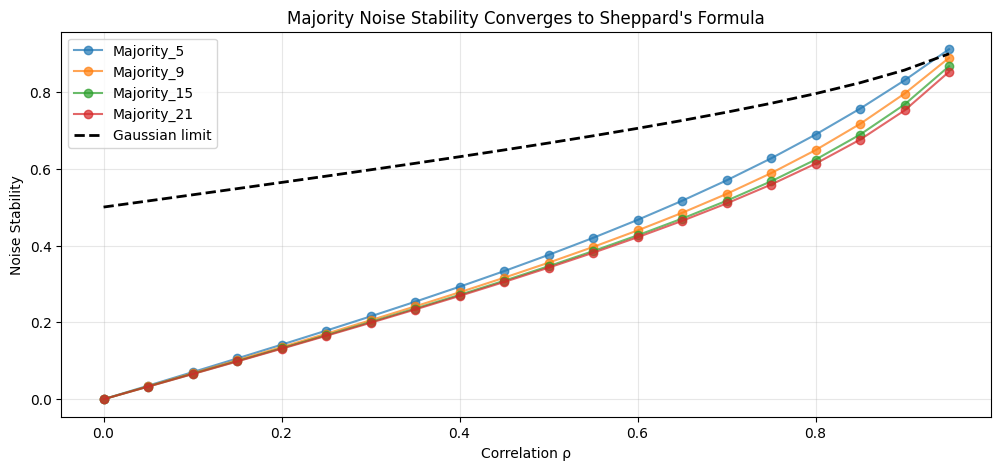

Sheppard's Formula: Stab_ρ[MAJ] → (1/2) + (1/π)·arcsin(ρ)

This is the key ingredient for 'Majority is Stablest'!


In [7]:
# Verify Sheppard's formula for Majority

def sheppard_formula(rho):
    """Gaussian noise stability limit: (1/2) + (1/π)arcsin(ρ)."""
    return 0.5 + np.arcsin(rho) / np.pi

rho_values = np.linspace(0, 0.95, 20)

plt.figure(figsize=(12, 5))

# Plot for various n
for n in [5, 9, 15, 21]:
    maj = bf.majority(n)
    # Direct API: f.noise_stability(rho)
    stabilities = [maj.noise_stability(rho) for rho in rho_values]
    plt.plot(rho_values, stabilities, 'o-', alpha=0.7, label=f'Majority_{n}')

# Plot the limit
gaussian_limit = [sheppard_formula(rho) for rho in rho_values]
plt.plot(rho_values, gaussian_limit, 'k--', linewidth=2, label='Gaussian limit')

plt.xlabel('Correlation ρ')
plt.ylabel('Noise Stability')
plt.title("Majority Noise Stability Converges to Sheppard's Formula")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("Sheppard's Formula: Stab_ρ[MAJ] → (1/2) + (1/π)·arcsin(ρ)")
print("\nThis is the key ingredient for 'Majority is Stablest'!")

## Summary

### Key Takeaways from HW4:

1. **Hypercontractivity (Bonami's Lemma)**:
   - $\|f\|_4 \leq 3^{d/2} \|f\|_2$ for degree-$d$ functions
   - Controls "tail behavior" of low-degree functions
   - The magic inequality that powers everything else!

2. **KKL Theorem**:
   - $\max_i \mathbf{Inf}_i[f] \geq \Omega(\mathbf{Var}[f] \cdot \log n / \mathbf{I}[f])$
   - Every non-trivial function has an influential variable
   - For Majority: max influence $\approx \Theta(\log n / \sqrt{n})$

3. **Friedgut's Junta Theorem**:
   - Low total influence ⟹ approximately a junta
   - $f$ with $\mathbf{I}[f] = K$ is $\varepsilon$-close to $2^{O(K/\varepsilon)}$-junta

4. **Noise Stability of Majority**:
   - $\mathbf{Stab}_\rho[\text{MAJ}_n] \to \frac{1}{2} + \frac{1}{\pi}\arcsin(\rho)$
   - This is the "most stable" among symmetric, balanced, monotone functions!

5. **"Majority is Stablest"** (Mossel-O'Donnell-Oleszkiewicz):
   - Among all *low-influence* functions, Majority is asymptotically most stable
   - Implies UGC-hardness of MAX-CUT!

### Using boofun (Direct API):

```python
import boofun as bf
from boofun.analysis.hypercontractivity import bonami_lemma_bound, kkl_lower_bound

# Noise stability - direct method!
maj = bf.majority(9)
stab = maj.noise_stability(rho=0.5)

# Influences and KKL - direct methods!
influences = maj.influences()
max_inf = max(influences)
total_inf = maj.total_influence()

# Growth tracking
from boofun.families import MajorityFamily, GrowthTracker
tracker = GrowthTracker(MajorityFamily())
tracker.mark("noise_stability", rho=0.5)
tracker.observe(n_values=[3, 5, 7, 9, 11, 13, 15])
tracker.plot("noise_stability")
```